# Multi-sourcing under Supply Uncertainty
Prepared by: Nickolas Freeman, PhD

This notebook will demonstrate different approaches to modeling supply uncertainty. This demonstration will utilize a dataset that contains information regarding the sales of three products, each of which has been previously ordered from multiple suppliers. The steps we take to prepare the data for optimization modeling serve as a refresher on the use of Python for data manipulation. The following code block imports several libraries that we will use for the analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyopsmgmt as pyop
from ipywidgets import interact
from gurobipy import *

Throughout the notebook, we will use variables to store parameter values as much as possible. The motivation for doing this is to demonstrate how to write code in a form that is amenable to automation with as few changes as possible. The following code block specifies a variable that holds the name of the data file.

In [2]:
data_filename = 'data.xlsx'

At this point, we are not sure exactly how the Excel file that contains the data is structures. The following code block creates a Pandas `ExcelFile` object using the the data file. This object has several attributes that we may use to gather information regarding the data's structure.

In [3]:
data_file = pd.ExcelFile(data_filename)

The following code block uses the `sheet_names` attribute of the `ExcelFile` object to generate a list of the sheet names contained in the Excel file.

In [4]:
data_file.sheet_names

['Sales_Data', 'Delivery_Data', 'Price_Data']

Suppose that we want to read the data contained in each sheet into a separate Pandas `DataFrame` so that we can view the data and access the contents of the sheets for further analysis. Although Python (or most other programming languages for that matter) do not permit variables to be created on-the-fly, Python dictionaries allow us to achieve the same result. Essentially, we can create a dictionary with keys for each worksheet in the Excel file. The value for each key will be the associated data stored as a Pandas `DataFrame`. The following code block creates such a dictionary, which we name `data`.

In [5]:
data = {}
for current_sheet in data_file.sheet_names:
    data[current_sheet] = pd.read_excel(data_filename, sheet_name = current_sheet)

The following code block iterates over the `data` object, printing the first three rows of each `DataFrame`.

In [6]:
for key in data.keys():
    print('-----------------')
    print(key)
    print('-----------------')
    print(data[key].head(3))
    print('\n')

-----------------
Sales_Data
-----------------
        Date  Product_A_Sales  Product_B_Sales  Product_C_Sales
0 2017-08-19              806              379             1495
1 2017-08-20              698              309             1445
2 2017-08-21              647              306             1508


-----------------
Delivery_Data
-----------------
         Date Product Supplier  On_Time     Yield  Unit_Cost  \
0  01/01/2015       B    Comp6        1  0.902671       0.80   
1  01/02/2015       A    Comp2        1  0.922248       1.18   
2  01/02/2015       C   Comp14        1  0.768681       2.53   

   Ship_From_Country  
0                  3  
1                  1  
2                  1  


-----------------
Price_Data
-----------------
  Product  Sales_Price
0       A         2.00
1       B         1.25
2       C         5.00




# Data Exploration

Before continuing, let's investigate the data to get a better understanding of the different cases we will be modeling. The following code block shows that the data associated with the `Sales_Data` key contains 500 sales observations for three products, A, B, and C, each in a separate column. Note that providing the `all` argument to the `describe` method tells Pandas that we would like to see information for non-numeric columns in addition to numeric columns.

In [7]:
data['Sales_Data'].describe(include = 'all')

,Date,Product_A_Sales,Product_B_Sales,Product_C_Sales
count,500,500.000000,500.000000,500.000000
unique,500,NaN,NaN,NaN
top,2017-10-30 00:00:00,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
first,2017-08-19 00:00:00,NaN,NaN,NaN
last,2018-12-31 00:00:00,NaN,NaN,NaN
mean,NaN,761.512000,322.606000,1498.430000
std,NaN,42.811535,38.569288,53.430204
min,NaN,647.000000,259.000000,1351.000000
25%,NaN,724.750000,291.000000,1463.000000


The following code block provides information regarding the data associated with the `Delivery_Data` key. Using this information, along with the first three rows printed earlier, it seems that this data includes shipment outcomes for various orders for the available products. In particular, there are 3000 observations for the three products (combined). In total, orders are placed with 16 unique suppliers and the data includes a binary field that represents whether or not each delivery was made *on-time*, the yield assoicated with each delivery, the unit cost charged, and a numeric field representing the country the order shipped from.

In [8]:
data['Delivery_Data'].describe(include='all')

,Date,Product,Supplier,On_Time,Yield,Unit_Cost,Ship_From_Country
count,3000,3000,3000,3000.000000,3000.000000,3000.000000,3000.000000
unique,1270,3,16,NaN,NaN,NaN,NaN
top,11/19/2017,C,Comp13,NaN,NaN,NaN,NaN
freq,9,1245,368,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,0.894000,0.831155,1.760477,1.232667
std,NaN,NaN,NaN,0.307889,0.046624,0.797020,0.497275
min,NaN,NaN,NaN,0.000000,0.714098,0.800000,1.000000
25%,NaN,NaN,NaN,1.000000,0.798552,1.180000,1.000000
50%,NaN,NaN,NaN,1.000000,0.833835,1.290000,1.000000
75%,NaN,NaN,NaN,1.000000,0.866595,2.530000,1.000000


The following code block provides insight into the data associated with the `Price_Data` key. There are only three records, one for each product. Thus, the data seems to be providing the sales price for each product.

In [9]:
data['Price_Data'].describe(include='all')

,Product,Sales_Price
count,3,3.000000
unique,3,NaN
top,A,NaN
freq,1,NaN
mean,NaN,2.750000
std,NaN,1.984313
min,NaN,1.250000
25%,NaN,1.625000
50%,NaN,2.000000
75%,NaN,3.500000


Since we are interested in modeling supply uncertainty, lets look at the `Delivery_Data` in more detail. The following code block provides the number of unique values for the *On_Time*, *Yield*, *Unit_Cost*, and *Ship_From_Country* columns, grouped by *Supplier* and *Product*. Apparently, each supplier only provides a single product, charges a fixed unit cost, and ships from a single country. As noted earlier, the *On_Time* column contains only two values, whereas the *Yield* column appears to be continuous.

In [10]:
data['Delivery_Data'].groupby(['Supplier','Product'])['On_Time','Yield','Unit_Cost','Ship_From_Country'].nunique()

,,On_Time,Yield,Unit_Cost,Ship_From_Country
Supplier,Product,,,,
Comp1,A,2,203,1,1
Comp10,B,2,107,1,1
Comp11,B,2,68,1,1
Comp12,B,2,60,1,1
Comp13,C,2,368,1,1
Comp14,C,2,312,1,1
Comp15,C,2,259,1,1
Comp16,C,2,306,1,1
Comp2,A,2,320,1,1


We will be incorporating both the on-time delivery performance and yield for suppliers in our models. For ease of reference, we will us the delivery data to create a function that creates a dictionary that we can use to easily access relevant supplier information. The following code block shows how we can use grouped data (as shown in the previous output) to capture information regarding the product supplied, the mean on-time delivery, the unit cost, and the ship from country for each supplier.

In [11]:
grouped_delivery_data = data['Delivery_Data'].groupby(['Supplier','Product'])['On_Time','Unit_Cost','Ship_From_Country'].mean()
for index, row in grouped_delivery_data.iterrows():
    print(f'''{index[0]} supplies product {index[1]} 
    from country {row["Ship_From_Country"]}
          at a cost of {row["Unit_Cost"]} 
          and an on-time delivery percent of {row["On_Time"]}\n''')
del(grouped_delivery_data)

Comp1 supplies product A 
    from country 1.0
          at a cost of 1.289999999999998 
          and an on-time delivery percent of 0.8522167487684729

Comp10 supplies product B 
    from country 1.0
          at a cost of 0.8599999999999995 
          and an on-time delivery percent of 0.9065420560747663

Comp11 supplies product B 
    from country 1.0
          at a cost of 0.9399999999999991 
          and an on-time delivery percent of 0.9558823529411765

Comp12 supplies product B 
    from country 2.0
          at a cost of 0.8200000000000002 
          and an on-time delivery percent of 0.8

Comp13 supplies product C 
    from country 1.0
          at a cost of 2.799999999999981 
          and an on-time delivery percent of 0.9565217391304348

Comp14 supplies product C 
    from country 1.0
          at a cost of 2.529999999999982 
          and an on-time delivery percent of 0.8141025641025641

Comp15 supplies product C 
    from country 1.0
          at a cost of 2.3500000000

The following code block defines a function that stores the information returned by the grouped object as a dictionary.

In [12]:
def create_supplier_info(delivery_data):
    
    supplier_info = {}
    
    grouped_delivery_data = delivery_data.groupby(['Supplier','Product'])['On_Time',
                                                                          'Yield',
                                                                          'Unit_Cost',
                                                                          'Ship_From_Country'].mean()
    
    for index, row in grouped_delivery_data.iterrows():
        supplier_info[index[0]] = {'Product': index[1],
                                   'Mean_OTD': row['On_Time'],
                                   'Mean_Yield': row['Yield'],
                                   'Unit_Cost': row['Unit_Cost'],
                                   'Ship_From_Country': row['Ship_From_Country']}
        
    return supplier_info

The following code block demonstrates how we can call the function.

In [13]:
supplier_info = create_supplier_info(data['Delivery_Data'])

Ultimately, we will be constructing stochastic optimization models based on the supplier information. As we saw in the previous class, we will incorprate the uncertainty using scenarios. Thus, our previous definition for the `create_supplier_info` should probably be revised to include the set of scenarios for on-time delivery and yield for each supplier. Since the yield is continuous, we can use our parametric or non-parametric methods to fit a distribution and generate the sample. The following code block shows how this can be performed for a particular supplier.

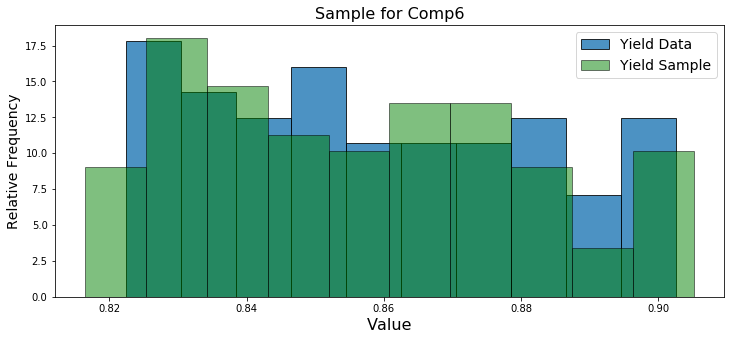

In [14]:
scenarios = 100

current_supplier = 'Comp6'
yield_vals = data['Delivery_Data'][data['Delivery_Data']['Supplier'] == current_supplier]['Yield'].values
best_params = pyop.dist_fit.fit_best_kde(yield_vals)
pdfx, pdfy = pyop.dist_fit.pdf_from_kde(yield_vals, bandwidth = best_params['bandwidth'], kernel = best_params['kernel'])
yield_sample = pyop.dist_fit.trunc_kde_sample(pdfx, pdfy, sample_size = scenarios)

fig, ax = plt.subplots(1, 1, figsize=(12,5))
ax.hist(yield_vals, label = 'Yield Data', alpha = 0.8, edgecolor = 'k', density = True)
ax.hist(yield_sample, label='Yield Sample', alpha = 0.5, color = 'g', edgecolor = 'k', density = True)
ax.set_title(f'Sample for {current_supplier}', fontsize = 16)
ax.set_xlabel('Value', fontsize = 16)
ax.set_ylabel('Relative Frequency', fontsize = 14)
ax.legend(fontsize = 14)
plt.show()

We will use a binomial distribution to generate scenarios for on-time delivery. From https://en.wikipedia.org/wiki/Binomial_distribution (accessed 3/20/2019):

>In probability theory and statistics, the binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question, and each with its own boolean-valued outcome: a random variable containing a single bit of information: success/yes/true/one (with probability p) or failure/no/false/zero (with probability q = 1 − p). A single success/failure experiment is also called a Bernoulli trial or Bernoulli experiment and a sequence of outcomes is called a Bernoulli process; for a single trial, i.e., n = 1, the binomial distribution is a Bernoulli distribution. The binomial distribution is the basis for the popular binomial test of statistical significance.

The following code block shows how we can use Numpy's binomial function to generate 100 scenarios for an example situation where on-time delivery is 80%.

In [15]:
my_sample = np.random.binomial(n = 1, p = 0.80, size = 100)
print(f'The first five values of the sample are {my_sample[:10]}')
print(f'The mean of the sample is {my_sample.mean()}')

The first five values of the sample are [1 1 1 0 1 1 1 1 1 0]
The mean of the sample is 0.79


The following code block generates a 10000 point sample and shows how the values will converge to the true probability as the sample size increases.

In [16]:
my_sample = np.random.binomial(n = 1, p = 0.80, size = 10000)
print(f'The first five values of the sample are {my_sample[:10]}')
print(f'The mean of the sample is {my_sample.mean()}')

The first five values of the sample are [1 1 1 1 1 1 1 1 1 0]
The mean of the sample is 0.8019


The following code block generates an on-time delivery sample for a specified supplier. Note that I am just using the mean on-time delivery value from the `supplier_info` object to define the probability.

In [17]:
scenarios = 100

current_supplier = 'Comp6'
np.random.binomial(n = 1, p = supplier_info[current_supplier]['Mean_OTD'], size = scenarios)

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1])

The following code block updates the `create_supplier_info` function to include sample generation. Note that we now require an additional argument that specifies the number of scenarios.

In [18]:
def create_supplier_info(delivery_data, scenarios):
    
    supplier_info = {}
    
    grouped_delivery_data = delivery_data.groupby(['Supplier','Product'])['On_Time',
                                                                          'Yield',
                                                                          'Unit_Cost',
                                                                          'Ship_From_Country'].mean()
    
    for index, row in grouped_delivery_data.iterrows():
        supplier_info[index[0]] = {'Product': index[1],
                                   'Mean_OTD': row['On_Time'],
                                   'Mean_Yield': row['Yield'],
                                   'Unit_Cost': row['Unit_Cost'],
                                   'Ship_From_Country': row['Ship_From_Country']}
        
    for current_supplier in supplier_info.keys():
        yield_vals = delivery_data[delivery_data['Supplier'] == current_supplier]['Yield'].values
        best_params = pyop.dist_fit.fit_best_kde(yield_vals)
        pdfx, pdfy = pyop.dist_fit.pdf_from_kde(yield_vals, bandwidth = best_params['bandwidth'], kernel = best_params['kernel'])
        yield_sample = pyop.dist_fit.trunc_kde_sample(pdfx, pdfy, sample_size = scenarios)
        supplier_info[current_supplier]['Yield_Sample'] = yield_sample
        
    for current_supplier in supplier_info.keys():
        supplier_info[current_supplier]['OTD_Sample'] = np.random.binomial(n = 1, 
                                                                           p = supplier_info[current_supplier]['Mean_OTD'], 
                                                                           size = scenarios)
        
    return supplier_info

The following code block demonstrates the use of the revised function.

In [19]:
supplier_info = create_supplier_info(data['Delivery_Data'], 100)

Next, we will move towards constructing a function for generating product info, i.e., a dictionary that contains a demand sample and the sales price for each product.

The following code block shows how we can *pick* the sales price information for a specific product from the `Price_Data`.

In [20]:
data['Price_Data'].loc[data['Price_Data']['Product']=='A','Sales_Price'].item()

2.0

The next challenge is fitting distributions for the product demands. Recall that the `Sales_Data` included columns containing the sales for each product. The following code block shows how we can use *list comprehensions* to get the products rather simply.

In [21]:
product_columns = [col for col in data['Sales_Data'].columns if 'Sales' in col]
print(f'The product columns are {product_columns}')

products = [col[8:-6] for col in product_columns]
print(f'The products are {products}')

The product columns are ['Product_A_Sales', 'Product_B_Sales', 'Product_C_Sales']
The products are ['A', 'B', 'C']


Combining these two techniques, the following function generates a dictionary of product information.

In [22]:
def create_product_info(sales_data, price_data, scenarios):
    
    product_info = {}
    
    product_columns = [col for col in sales_data.columns if 'Sales' in col]
    products = [col[8:-6] for col in product_columns]
    
    for current_product in products:
        column_name = 'Product_' + current_product + '_Sales'
        sales_vals = sales_data[column_name].values
        best_params = pyop.dist_fit.fit_best_kde(sales_vals)
        pdfx, pdfy = pyop.dist_fit.pdf_from_kde(sales_vals, bandwidth = best_params['bandwidth'], kernel = best_params['kernel'])
        demand_sample = pyop.dist_fit.trunc_kde_sample(pdfx, pdfy, sample_size = scenarios)
        product_info[current_product] = {'Demand_Sample': demand_sample,
                                        'Sales_Price': price_data.loc[price_data['Product']==current_product,
                                                                      'Sales_Price'].item()}
        
        
    return product_info

The following code block demonstrates the previously defined functions use.

In [23]:
product_info = create_product_info(data['Sales_Data'], data['Price_Data'], 100)

# Modeling Uncertain On-time Delivery

We will now use the objects we have created to model a situation with uncertain on-time delivery. We will define a function for this purpose, which will allow us to easily iterate over all of the products. The function will take a current product, and our `supplier_info` and ` product_info` objects as arguments. The following code block shows how we will use the current product and `supplier_info` object to determine the relevant suppliers. 

In [24]:
current_product = 'A'
relevant_suppliers = [supplier for supplier in supplier_info.keys() if current_product == supplier_info[supplier]['Product']]
print(f'The supplier for product {current_product} are {relevant_suppliers}')

The supplier for product A are ['Comp1', 'Comp2', 'Comp3', 'Comp4', 'Comp5']


We use the following mathematical model.

<u>Sets</u><br>
$S$ - set of suppliers.<br>
$\Omega$ - set of scenarios.<br>
<br>
<u>Indices</u><br>
$s$ - supplier index, $s \in S$.<br>
$\omega$ - scenario index, $\omega \in \Omega$.<br>
<br>
<u>Parameters</u><br>
$p$ - unit sales price.<br>
$c_{s}$ - unit cost charged by supplier $s$.<br>
$d_{\omega}$ - demand in scenario $\omega$.<br>
$\alpha_{s\omega}$ - 1, if supplier $s$ delivers in scenario $\omega$; $0$, otherwise.<br>
<br>
<u>Variables</u><br>
$Q_{S}$ - amount ordered from supplier $s$.<br>
$S_{\omega}$ - amount sold in scenario $\omega$.<br>

$$\displaystyle Maximize \sum_{\omega \in \Omega}\left(pS_{\omega}- \sum_{s\in S}c_{s}\alpha_{s\omega}Q_{s}\right)\bigg/|\Omega|$$


$$Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq \sum_{s\in S}\alpha_{s\omega}Q_{s}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q_{s} \geq 0,~~~~\forall s \in S.$$

The following code block defines our model for incorporating uncertain on-time delivery.

In [25]:
def solve_OTD_model(current_product, product_info, supplier_info):
    
    demand_sample = product_info[current_product]['Demand_Sample']
    sales_price = product_info[current_product]['Sales_Price']
    relevant_suppliers = [supplier for supplier in supplier_info.keys() if current_product == supplier_info[supplier]['Product']]
    scenarios = len(demand_sample)

    m = Model(name = 'Sourcing Under All-or-Nothing Disruptions')
    m.setParam('OutputFlag', 0)

    Order = m.addVars(relevant_suppliers, vtype = 'C', name="Order")
    Sell = m.addVars(scenarios, vtype = 'C', name = "Sell")
    
    for scenario in range(scenarios):
        total_delivered = LinExpr()
        for supplier in relevant_suppliers:
            total_delivered.add(Order[supplier]*supplier_info[supplier]['OTD_Sample'][scenario])
        m.addConstr(Sell[scenario] <= total_delivered, name = 'Sell <= Delivered')

    for scenario in range(scenarios):
        m.addConstr(Sell[scenario] <= demand_sample[scenario], name = 'Sell <= Demand')

    expected_revenue = LinExpr()
    for scenario in range(scenarios):
        expected_revenue.add(sales_price*Sell[scenario])
    expected_revenue = expected_revenue/scenarios

    expected_cost = LinExpr()
    for scenario in range(scenarios): 
        for supplier in relevant_suppliers:
            expected_cost.add(supplier_info[supplier]['Unit_Cost']*Order[supplier]\
                              *supplier_info[supplier]['OTD_Sample'][scenario])
    expected_cost = expected_cost/scenarios

    objective = expected_revenue - expected_cost
    m.setObjective(objective, GRB.MAXIMIZE) # maximize profit

    m.optimize()
    
    solution_dict = {}
    for supplier in relevant_suppliers:
        solution_dict[supplier] = Order[supplier].X

    return solution_dict

The following code block shows that the function returns a dictionary with the optimal order quantity from each supplier.

In [26]:
solve_OTD_model('A', product_info, supplier_info)

Academic license - for non-commercial use only


{'Comp1': 28.951351351351377,
 'Comp2': 80.17297297297307,
 'Comp3': 664.5069069069068,
 'Comp4': 0.0,
 'Comp5': 0.0}

To see the fruits of our labor, the following code block shows how our functions work together to solve the uncertain on-time delivery model for all products.

In [27]:
scenarios = 1000
product_info = create_product_info(data['Sales_Data'], data['Price_Data'], scenarios)
supplier_info = create_supplier_info(data['Delivery_Data'], scenarios)

for current_product in product_info.keys():
    print('------------')
    print(f'Product {current_product}')
    print('------------')
    solution = solve_OTD_model(current_product, product_info, supplier_info)
    
    for key in solution.keys():
        print(f'Order {solution[key]} from {key}')
    print('\n')

------------
Product A
------------
Order 0.0 from Comp1
Order 49.48948948948953 from Comp2
Order 703.8510510510511 from Comp3
Order 6.433633633633576 from Comp4
Order 0.0 from Comp5


------------
Product B
------------
Order 20.814414414414387 from Comp10
Order 0.0 from Comp11
Order 30.856456456456442 from Comp12
Order 223.16816816816822 from Comp6
Order 0.0 from Comp7
Order 34.87327327327324 from Comp8
Order 0.0 from Comp9


------------
Product C
------------
Order 14.479279279279126 from Comp13
Order 56.15135135135142 from Comp14
Order 1439.9063063063063 from Comp15
Order 0.0 from Comp16




# Yield Uncertainty

We will now consider yield uncertainty using the following mathematical model.

<u>Sets</u><br>
$S$ - set of suppliers.<br>
$\Omega$ - set of scenarios.<br>
<br>
<u>Indices</u><br>
$s$ - supplier index, $s \in S$.<br>
$\omega$ - scenario index, $\omega \in \Omega$.<br>
<br>
<u>Parameters</u><br>
$p$ - unit sales price.<br>
$c_{s}$ - unit cost charged by supplier $s$.<br>
$d_{\omega}$ - demand in scenario $\omega$.<br>
$\beta_{s\omega}$ - yield proportion for supplier $s$ in scenario $\omega$<br>
<br>
<u>Variables</u><br>
$Q_{S}$ - amount ordered from supplier $s$.<br>
$S_{\omega}$ - amount sold in scenario $\omega$.<br>

$$\displaystyle Maximize \sum_{\omega \in \Omega}\left(pS_{\omega}- \sum_{s\in S}c_{s}\beta_{s\omega}Q_{s}\right)\bigg/|\Omega|$$


$$Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq \sum_{s\in S}\beta_{s\omega}Q_{s}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q_{s} \geq 0,~~~~\forall s \in S.$$

The following code block defines our model for incorporating uncertain yield.

In [28]:
def solve_uncertain_yield_model(current_product, product_info, supplier_info):
    
    demand_sample = product_info[current_product]['Demand_Sample']
    sales_price = product_info[current_product]['Sales_Price']
    relevant_suppliers = [supplier for supplier in supplier_info.keys() if current_product == supplier_info[supplier]['Product']]
    scenarios = len(demand_sample)

    m = Model(name = 'Sourcing Under Uncertain Yield')
    m.setParam('OutputFlag', 0)

    Order = m.addVars(relevant_suppliers, vtype = 'C', name="Order")
    Sell = m.addVars(scenarios, vtype = 'C', name = "Sell")
    
    for scenario in range(scenarios):
        total_delivered = LinExpr()
        for supplier in relevant_suppliers:
            total_delivered.add(Order[supplier]*supplier_info[supplier]['Yield_Sample'][scenario])
        m.addConstr(Sell[scenario] <= total_delivered, name = 'Sell <= Delivered')

    for scenario in range(scenarios):
        m.addConstr(Sell[scenario] <= demand_sample[scenario], name = 'Sell <= Demand')

    expected_revenue = LinExpr()
    for scenario in range(scenarios):
        expected_revenue.add(sales_price*Sell[scenario])
    expected_revenue = expected_revenue/scenarios

    expected_cost = LinExpr()
    for scenario in range(scenarios): 
        for supplier in relevant_suppliers:
            expected_cost.add(supplier_info[supplier]['Unit_Cost']*Order[supplier]\
                              *supplier_info[supplier]['Yield_Sample'][scenario])
    expected_cost = expected_cost/scenarios

    objective = expected_revenue - expected_cost
    m.setObjective(objective, GRB.MAXIMIZE) # maximize profit

    m.optimize()
    
    solution_dict = {}
    for supplier in relevant_suppliers:
        solution_dict[supplier] = Order[supplier].X

    return solution_dict

The following code block solves the uncertain yield model for all products.

In [29]:
scenarios = 1000
product_info = create_product_info(data['Sales_Data'], data['Price_Data'], scenarios)
supplier_info = create_supplier_info(data['Delivery_Data'], scenarios)

for current_product in product_info.keys():
    print('------------')
    print(f'Product {current_product}')
    print('------------')
    solution = solve_uncertain_yield_model(current_product, product_info, supplier_info)
    
    for key in solution.keys():
        print(f'Order {solution[key]} from {key}')
    print('\n')

------------
Product A
------------
Order 0.0 from Comp1
Order 14.148223866856734 from Comp2
Order 937.4855224045237 from Comp3
Order 0.0 from Comp4
Order 0.0 from Comp5


------------
Product B
------------
Order 0.0 from Comp10
Order 0.0 from Comp11
Order 0.0 from Comp12
Order 357.9165734417662 from Comp6
Order 0.0 from Comp7
Order 0.0 from Comp8
Order 0.0 from Comp9


------------
Product C
------------
Order 0.0 from Comp13
Order 0.0 from Comp14
Order 1725.5548541325315 from Comp15
Order 0.0 from Comp16




# All-or-Nothing Disruptions and Yield Uncertainty

We will now consider both all-or-nothing disruptions and yield uncertainty using the following mathematical model.

<u>Sets</u><br>
$S$ - set of suppliers.<br>
$\Omega$ - set of scenarios.<br>
<br>
<u>Indices</u><br>
$s$ - supplier index, $s \in S$.<br>
$\omega$ - scenario index, $\omega \in \Omega$.<br>
<br>
<u>Parameters</u><br>
$p$ - unit sales price.<br>
$c_{s}$ - unit cost charged by supplier $s$.<br>
$d_{\omega}$ - demand in scenario $\omega$.<br>
$\alpha_{s\omega}$ - 1, if supplier $s$ delivers in scenario $\omega$; $0$, otherwise.<br>
$\beta_{s\omega}$ - yield proportion for supplier $s$ in scenario $\omega$<br>
<br>
<u>Variables</u><br>
$Q_{S}$ - amount ordered from supplier $s$.<br>
$S_{\omega}$ - amount sold in scenario $\omega$.<br>

$$\displaystyle Maximize \sum_{\omega \in \Omega}\left(pS_{\omega}- \sum_{s\in S}c_{s}\alpha_{s\omega}\beta_{s\omega}Q_{s}\right)\bigg/|\Omega|$$


$$Subject~to,\hspace{7cm}~$$
$$\displaystyle S_{\omega} \leq \sum_{s\in S}\alpha_{s\omega}\beta_{s\omega}Q_{s}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \leq d_{\omega}, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle S_{\omega} \geq 0, ~~~~\forall \omega \in \Omega,$$
$$\displaystyle Q_{s} \geq 0,~~~~\forall s \in S.$$

The following code block defines our model for incorporating uncertain yield.

In [30]:
def solve_uncertain_yield_and_OTD_model(current_product, product_info, supplier_info):
    
    demand_sample = product_info[current_product]['Demand_Sample']
    sales_price = product_info[current_product]['Sales_Price']
    relevant_suppliers = [supplier for supplier in supplier_info.keys() if current_product == supplier_info[supplier]['Product']]
    scenarios = len(demand_sample)

    m = Model(name = 'Sourcing Under Uncertain Yield')
    m.setParam('OutputFlag', 0)

    Order = m.addVars(relevant_suppliers, vtype = 'C', name="Order")
    Sell = m.addVars(scenarios, vtype = 'C', name = "Sell")
    
    for scenario in range(scenarios):
        total_delivered = LinExpr()
        for supplier in relevant_suppliers:
            total_delivered.add(Order[supplier]*supplier_info[supplier]['Yield_Sample'][scenario]\
                               *supplier_info[supplier]['OTD_Sample'][scenario])
        m.addConstr(Sell[scenario] <= total_delivered, name = 'Sell <= Delivered')

    for scenario in range(scenarios):
        m.addConstr(Sell[scenario] <= demand_sample[scenario], name = 'Sell <= Demand')

    expected_revenue = LinExpr()
    for scenario in range(scenarios):
        expected_revenue.add(sales_price*Sell[scenario])
    expected_revenue = expected_revenue/scenarios

    expected_cost = LinExpr()
    for scenario in range(scenarios): 
        for supplier in relevant_suppliers:
            expected_cost.add(supplier_info[supplier]['Unit_Cost']*Order[supplier]\
                              *supplier_info[supplier]['Yield_Sample'][scenario]\
                              *supplier_info[supplier]['OTD_Sample'][scenario])
    expected_cost = expected_cost/scenarios

    objective = expected_revenue - expected_cost
    m.setObjective(objective, GRB.MAXIMIZE) # maximize profit

    m.optimize()
    
    solution_dict = {}
    for supplier in relevant_suppliers:
        solution_dict[supplier] = Order[supplier].X

    return solution_dict

The following code block solves the combined model for all products.

In [31]:
scenarios = 1000
product_info = create_product_info(data['Sales_Data'], data['Price_Data'], scenarios)
supplier_info = create_supplier_info(data['Delivery_Data'], scenarios)

for current_product in product_info.keys():
    print('------------')
    print(f'Product {current_product}')
    print('------------')
    solution = solve_uncertain_yield_and_OTD_model(current_product, product_info, supplier_info)
    
    for key in solution.keys():
        print(f'Order {solution[key]} from {key}')
    print('\n')

------------
Product A
------------
Order 0.0 from Comp1
Order 2.293711110763181 from Comp2
Order 950.6114786029202 from Comp3
Order 0.0 from Comp4
Order 0.0 from Comp5


------------
Product B
------------
Order 22.829982401951376 from Comp10
Order 0.0 from Comp11
Order 28.066602345884203 from Comp12
Order 294.0058633953323 from Comp6
Order 0.0 from Comp7
Order 23.653318826615983 from Comp8
Order 0.0 from Comp9


------------
Product C
------------
Order 0.4376300386444763 from Comp13
Order 2.479932490240259 from Comp14
Order 1723.1922024154774 from Comp15
Order 0.0 from Comp16




# Solution Comparison

The following code block demonstrates how our functions and models may be used to solve all variants of the problem for all products and output the results to an Excel file.

In [32]:
data_filename = 'data.xlsx'
data_file = pd.ExcelFile(data_filename)
data = {}
for current_sheet in data_file.sheet_names:
    data[current_sheet] = pd.read_excel(data_filename, sheet_name = current_sheet)

scenarios = 1000
product_info = create_product_info(data['Sales_Data'], data['Price_Data'], scenarios)
supplier_info = create_supplier_info(data['Delivery_Data'], scenarios)

with pd.ExcelWriter('output.xlsx') as writer:  

    for current_product in product_info.keys():
        print(f'Starting product {current_product}')
        OTD_solution = solve_OTD_model(current_product, product_info, supplier_info)
        yield_solution = solve_uncertain_yield_model(current_product, product_info, supplier_info)
        OTD_and_yield_solution = solve_uncertain_yield_and_OTD_model(current_product, product_info, supplier_info)

        supplier_list = []
        OTD_list = []
        yield_list = []
        OTD_and_yield_list = []

        for key in OTD_solution.keys():
            supplier_list.append(key)
            OTD_list.append(OTD_solution[key])
            yield_list.append(yield_solution[key])
            OTD_and_yield_list.append(OTD_and_yield_solution[key])
            
        pd.DataFrame.from_dict({'Supplier': supplier_list,
                                'OTD_Solution': OTD_list,
                                'Yield_Solution': yield_list,
                                'OTD_and_Yield_Solution': OTD_and_yield_list}).to_excel(writer, 
                                                                                        sheet_name=f'Product_{current_product}',
                                                                                        index = False)

Starting product A
Starting product B
Starting product C
